# --- 1. CONFIGURACIÓN DEL ENTORNO ---

In [1]:
# --- 1. CONFIGURACIÓN DEL ENTORNO ---
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.features import DivIcon
from geopy.distance import geodesic
from datetime import datetime, timedelta
import os
import warnings

# Limpieza de visualización
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
print(f"✅ Entorno configurado en: {os.getcwd()}")

✅ Entorno configurado en: c:\Users\arias\OneDrive\z. Proyectos BI\F1_Sustainable_Logistics\notebooks


# --- 2. CLASE DE GESTIÓN DE DATOS ---

In [2]:
# --- 2. CLASE DE GESTIÓN DE DATOS ---
class F1LogisticsData:
    def __init__(self, circuits_path, params_path, constraints_path):
        """Carga datos maestros, parámetros y restricciones duras."""
        
        # 1. Cargar Circuitos
        if not os.path.exists(circuits_path): raise FileNotFoundError(f"❌ Falta {circuits_path}")
        self.df = pd.read_csv(circuits_path)
        self.num_races = len(self.df)
        self.id_to_index = pd.Series(self.df.index, index=self.df['ID']).to_dict()
        
        # Convertir fechas
        self.df['Ventana_Inicio'] = pd.to_datetime(self.df['Ventana_Inicio'])
        self.df['Ventana_Fin'] = pd.to_datetime(self.df['Ventana_Fin'])
        
        # 2. Cargar Parámetros
        self.params = self._load_key_value_csv(params_path, 'Parametro', 'Valor')
        
        # 3. Cargar Restricciones de Inicio/Fin (Anclas)
        self.constraints = self._load_key_value_csv(constraints_path, 'Restriccion', 'Valor_ID')
        
        # 4. Matriz de Distancias
        self.distance_matrix = self._calculate_distance_matrix()

    def _load_key_value_csv(self, path, col_key, col_val):
        if not os.path.exists(path): raise FileNotFoundError(f"❌ Falta {path}")
        df = pd.read_csv(path)
        return pd.Series(df[col_val].values, index=df[col_key]).to_dict()

    def _calculate_distance_matrix(self):
        matrix = np.zeros((self.num_races, self.num_races))
        coords = self.df[['Latitud', 'Longitud']].to_numpy()
        for i in range(self.num_races):
            for j in range(self.num_races):
                if i != j: matrix[i][j] = geodesic(coords[i], coords[j]).kilometers
        return matrix

    def get_coordinates(self, race_idx):
        return [self.df.iloc[race_idx]['Latitud'], self.df.iloc[race_idx]['Longitud']]

    def get_race_info(self, race_idx):
        return self.df.iloc[race_idx]
    
    def get_fixed_start_end_indices(self):
        """Devuelve los ÍNDICES (no IDs) de las carreras de inicio y fin configuradas."""
        start_id = self.constraints.get('Start_Race_ID')
        end_id = self.constraints.get('End_Race_ID')
        
        idx_start = self.id_to_index.get(start_id)
        idx_end = self.id_to_index.get(end_id)
        
        if idx_start is None or idx_end is None:
            raise ValueError("❌ Error: Los IDs de Inicio/Fin en race_constraints.csv no existen en f1_circuits.csv")
            
        return idx_start, idx_end

    def load_official_route(self, calendar_path):
        if not os.path.exists(calendar_path): raise FileNotFoundError(f"❌ Falta {calendar_path}")
        cal_df = pd.read_csv(calendar_path)
        return [self.id_to_index[row['Circuito_ID']] for _, row in cal_df.iterrows() if row['Circuito_ID'] in self.id_to_index]

# --- 3. MOTOR DE OPTIMIZACIÓN (GENÉTICO) ---

In [3]:
# --- 3. MOTOR DE OPTIMIZACIÓN (CON EARLY STOPPING AJUSTADO) ---
class SustainableOptimizer:
    def __init__(self, data_manager, pop_size=100, generations=500, mutation_rate=0.20):
        self.dm = data_manager
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.history = []
        
        # OBTENER ANCLAS
        self.fixed_start, self.fixed_end = self.dm.get_fixed_start_end_indices()
        all_indices = set(range(self.dm.num_races))
        self.middle_indices = list(all_indices - {self.fixed_start, self.fixed_end})

    def _calculate_logistics_kpi(self, total_dist_km):
        p = self.dm.params
        fuel_liters = total_dist_km * 12 
        total_co2_ton = (fuel_liters * 3.16) / 1000
        costo_fuel = fuel_liters * p['Costo_JetFuel_USD_L']
        costo_ops = total_dist_km * 250 
        total_cost_usd = costo_fuel + costo_ops
        transit_hours = total_dist_km / 60
        setup_hours = self.dm.num_races * 48
        total_hours = transit_hours + setup_hours
        return total_cost_usd, total_co2_ton, fuel_liters, total_hours

    def _check_date_constraints(self, route):
        penalty_score = 0
        violations = 0
        current_date = datetime(2025, 3, 1) 
        
        for race_idx in route:
            row = self.dm.df.iloc[race_idx]
            win_start = row['Ventana_Inicio']
            win_end = row['Ventana_Fin']
            
            if win_start <= current_date <= win_end: days_diff = 0
            else:
                diff_start = abs((current_date - win_start).days)
                diff_end = abs((current_date - win_end).days)
                days_diff = min(diff_start, diff_end)
            
            # SEMÁFORO DE RIESGO
            if days_diff <= 7: penalty_score += 0
            elif days_diff <= 45: penalty_score += 2_500_000 
            else:
                penalty_score += 100_000_000 
                violations += 1
            current_date += timedelta(days=11)
        return penalty_score, violations

    def fitness(self, route):
        total_dist = 0
        for i in range(len(route) - 1):
            total_dist += self.dm.distance_matrix[route[i]][route[i+1]]
        cost_usd, co2_ton, fuel_L, hours = self._calculate_logistics_kpi(total_dist)
        date_penalty, _ = self._check_date_constraints(route)
        total_score = cost_usd + date_penalty
        return total_score, total_dist, cost_usd, co2_ton, fuel_L, hours

    def _crossover(self, p1, p2):
        mid_p1 = p1[1:-1]
        mid_p2 = p2[1:-1]
        start_cut, end_cut = sorted(random.sample(range(len(mid_p1)), 2))
        child_mid = [-1] * len(mid_p1)
        child_mid[start_cut:end_cut] = mid_p1[start_cut:end_cut]
        pointer = 0
        for gene in mid_p2:
            if gene not in child_mid:
                while child_mid[pointer] != -1: pointer += 1
                child_mid[pointer] = gene
        return [p1[0]] + child_mid + [p1[-1]]

    def _mutate(self, route):
        if len(route) > 3:
            idx_range = range(1, len(route)-1)
            a, b = random.sample(idx_range, 2)
            route[a], route[b] = route[b], route[a]
        return route

    # --- MÉTODO RUN CON PACIENCIA (150) ---
    def run(self):
        population = []
        for _ in range(self.pop_size):
            middle = random.sample(self.middle_indices, len(self.middle_indices))
            indiv = [self.fixed_start] + middle + [self.fixed_end]
            population.append(indiv)
        
        best_route = None
        best_fitness = float('inf')
        
        # --- CONFIGURACIÓN DE PARADA ---
        generations_without_improvement = 0
        PATIENCE_LIMIT = 150  # <--- AJUSTE (PACIENCIA)
        
        for gen in range(self.generations):
            pop_fitness = []
            for indiv in population:
                score, _, _, _, _, _ = self.fitness(indiv)
                pop_fitness.append((score, indiv))
                
                if score < best_fitness:
                    best_fitness = score
                    best_route = indiv
                    generations_without_improvement = 0
            
            # Verificamos si el mejor de la población actual supera al histórico
            # Si no hay mejora global, sumamos impaciencia
            if pop_fitness[0][0] >= best_fitness:
                generations_without_improvement += 1
            
            # EARLY STOPPING
            if generations_without_improvement >= PATIENCE_LIMIT:
                # print(f"   🚀 Convergencia estable tras {gen} gens. Deteniendo.")
                break

            _, _, cost_hist, _, _, _ = self.fitness(best_route)
            self.history.append(cost_hist)
            
            pop_fitness.sort(key=lambda x: x[0])
            survivors = [x[1] for x in pop_fitness[:int(self.pop_size/2)]]
            
            new_population = survivors[:]
            while len(new_population) < self.pop_size:
                p1, p2 = random.sample(survivors, 2)
                child = self._crossover(p1, p2)
                if random.random() < self.mutation_rate:
                    child = self._mutate(child)
                new_population.append(child)
            population = new_population

        return best_route, best_fitness

# --- 4. VISUALIZACIÓN Y REPORTES ---

In [4]:
# --- 4. VISUALIZACIÓN, INSIGHTS, AUDITORÍA Y DASHBOARD WEB ---
from folium.features import DivIcon
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

class LogisticsVisualizer:
    def __init__(self, data_manager):
        self.dm = data_manager

    # --- 1. GRÁFICAS ESTÁTICAS (Matplotlib) ---
    def plot_convergence(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history, color='#2c3e50', linewidth=1.5, alpha=0.6, label='Costo Raw')
        suavizado = pd.Series(history).rolling(window=20).mean()
        plt.plot(suavizado, color='#e74c3c', linewidth=2.5, label='Tendencia')
        plt.title('Convergencia del Modelo (Costo Logístico)', fontsize=14)
        plt.xlabel('Generaciones')
        plt.ylabel('USD')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # --- 2. MAPAS INTERACTIVOS (Folium) ---
    def _add_labels_to_map(self, m_layer, route, color_bg):
        for orden, race_idx in enumerate(route):
            info = self.dm.get_race_info(race_idx)
            lat, lon = info['Latitud'], info['Longitud']
            folium.CircleMarker([lat, lon], radius=4, color='white', fill=True, fill_color=color_bg, fill_opacity=1).add_to(m_layer)
            html = f"""<div style="font-size: 8pt; font-weight: bold; color: black; 
                    background-color: rgba(255, 255, 255, 0.7); border: 1px solid {color_bg};
                    border-radius: 3px; padding: 0px 2px; white-space: nowrap;">
                    {orden+1}. {info['Ciudad']}</div>"""
            folium.map.Marker([lat, lon], icon=DivIcon(icon_size=(100,20), icon_anchor=(0,-5), html=html)).add_to(m_layer)

    def create_side_by_side_map(self, route_base, route_opt, filename="../outputs/mapa_comparativo_dual.html"):
        m = plugins.DualMap(location=[25, 10], zoom_start=2, layout='vertical')
        
        # IZQUIERDA
        c_base = [self.dm.get_coordinates(i) for i in route_base]
        plugins.AntPath(c_base, color='#ff4d4d', weight=2, opacity=0.5, dash_array=[10, 20]).add_to(m.m1)
        self._add_labels_to_map(m.m1, route_base, '#ff4d4d')

        # DERECHA
        c_opt = [self.dm.get_coordinates(i) for i in route_opt]
        plugins.AntPath(c_opt, color='#00e676', weight=4, opacity=0.9, pulse_color='#FFFFFF').add_to(m.m2)
        self._add_labels_to_map(m.m2, route_opt, '#00e676')

        m.save(filename)
        return m

    # --- 3. AUDITORÍA Y REPORTES DE TEXTO ---
    def print_audit_details(self, route_opt):
        print("\n" + "="*80)
        print(f"{'🕵️‍♂️ AUDITORÍA DE ZONAS DE RIESGO':^80}")
        print("="*80)
        
        current_date = datetime(2025, 3, 1)
        warnings_yellow = 0
        violations_red = 0
        
        for i, idx in enumerate(route_opt):
            info = self.dm.get_race_info(idx)
            win_start = info['Ventana_Inicio']
            win_end = info['Ventana_Fin']
            
            if win_start <= current_date <= win_end: days_diff = 0
            else:
                diff_start = abs((current_date - win_start).days)
                diff_end = abs((current_date - win_end).days)
                days_diff = min(diff_start, diff_end)

            fecha_sim = current_date.strftime('%d-%b')
            if days_diff > 45:
                print(f"🔴 ERROR CRÍTICO (Ronda {i+1} {info['Ciudad']}): Desviación {days_diff} días.")
                violations_red += 1
            elif days_diff > 7:
                print(f"🟡 ALERTA GESTIONADA (Ronda {i+1} {info['Ciudad']}): Fecha {fecha_sim}. Desviación {days_diff} días.")
                warnings_yellow += 1
            current_date += timedelta(days=11)
            
        if violations_red == 0: print(f"\n✅ RESULTADO: Calendario APROBADO. (Zonas Amarillas usadas: {warnings_yellow})")
        else: print(f"\n❌ RESULTADO: RECHAZADO ({violations_red} errores críticos).")

    def print_report(self, route_base, route_opt, optimizer):
        _, d_base, c_base, co2_base, _, _ = optimizer.fitness(route_base)
        _, d_opt, c_opt, co2_opt, _, _ = optimizer.fitness(route_opt)
        
        diff_km = ((d_base - d_opt) / d_base) * 100
        diff_usd = (c_base - c_opt) / 1e6
        
        print("\n" + "="*80)
        print(f"{'🏁 RESUMEN EJECUTIVO (CONSOLA) 🏁':^80}")
        print("="*80)
        print(f"{'Métrica':<20} | {'Actual':<15} | {'Optimizado':<15} | {'Diferencia'}")
        print("-" * 70)
        print(f"{'Distancia':<20} | {d_base:,.0f} km     | {d_opt:,.0f} km     | 📉 {diff_km:.1f}%")
        print(f"{'Costo':<20} | ${c_base/1e6:.1f}M       | ${c_opt/1e6:.1f}M       | 💰 ${diff_usd:.1f}M")
        print(f"{'Emisiones':<20} | {co2_base:,.0f} t     | {co2_opt:,.0f} t     | 🌿 -{co2_base-co2_opt:,.0f} t")

    def print_schedule(self, route_opt):
        print("\n" + "="*80)
        print(f"{'📅 CALENDARIO FINAL':^80}")
        print("="*80)
        print(f"{'Ronda':<6} | {'Gran Premio':<25} | {'Ciudad':<20} | {'Ventana'}")
        print("-" * 75)
        for i, idx in enumerate(route_opt):
            info = self.dm.get_race_info(idx)
            print(f"{i+1:<6} | {info['Circuito']:<25} | {info['Ciudad']:<20} | {info['Ventana_Inicio'].strftime('%b')}-{info['Ventana_Fin'].strftime('%b')}")

    def generate_markdown_for_web(self, route_base, route_opt, optimizer):
        _, d_base, c_base, co2_base, _, hours_base = optimizer.fitness(route_base)
        _, d_opt, c_opt, co2_opt, fuel_opt, hours_opt = optimizer.fitness(route_opt)
        
        ahorro_km = ((d_base - d_opt) / d_base) * 100
        ahorro_usd = (c_base - c_opt) / 1e6
        dias_ahorrados = (hours_base - hours_opt) / 24
        
        md = f"""
## 🚀 Resultados: Optimización Logística F1 (2025)

### 📊 Tabla de Impacto

| KPI | Calendario Oficial | Propuesta IA | Ahorro / Mejora |
| :--- | :--- | :--- | :--- |
| **Distancia** | {d_base:,.0f} km | **{d_opt:,.0f} km** | 📉 {ahorro_km:.1f}% |
| **Costo Est.** | ${c_base/1e6:.1f}M USD | **${c_opt/1e6:.1f}M USD** | 💰 ${ahorro_usd:.1f}M USD |
| **Tiempo Total** | {hours_base/24:.0f} Días | **{hours_opt/24:.0f} Días** | ⏱️ {dias_ahorrados:.1f} Días Libres |

### 💡 Análisis Técnico
1. **Ruta Anclada:** Se respetó estrictamente el inicio en Australia y el fin en Abu Dhabi.
2. **Eficiencia:** La optimización reduce la huella de carbono equivalente a **{fuel_opt:,.0f} Litros** de Jet Fuel.
3. **Gestión de Riesgo:** El modelo utiliza un sistema de "Zonas de Tolerancia" para negociar fechas difíciles sin romper la viabilidad operativa.
"""
        print("\n" + "="*80)
        print("📝 SNIPPET MARKDOWN FINAL")
        print("="*80)
        print(md)

    # --- 4. DASHBOARD HTML INTERACTIVO ---
    def generate_interactive_dashboard(self, route_base, route_opt, optimizer, history_data, filename="../outputs/dashboard_ejecutivo.html"):
        """Genera Dashboard con 3 gráficos separados y KPIs detallados."""
        # 1. Calcula Datos
        _, d_base, c_base, co2_base, _, h_base = optimizer.fitness(route_base)
        _, d_opt, c_opt, co2_opt, _, h_opt = optimizer.fitness(route_opt)
        
        diff_km = d_base - d_opt
        diff_usd = c_base - c_opt
        diff_co2 = co2_base - co2_opt
        diff_days = (h_base - h_opt) / 24

        # 2. Genera Gráficos Separados
        
        def create_kpi_chart(title, y_label, val_base, val_opt, color_base, color_opt):
            fig = go.Figure()
            fig.add_trace(go.Bar(
                x=['Actual', 'Optimizado'],
                y=[val_base, val_opt],
                marker_color=[color_base, color_opt],
                text=[f"{val_base:,.0f}", f"{val_opt:,.0f}"],
                textposition='auto',
            ))
            fig.update_layout(
                title=title, 
                yaxis_title=y_label,
                template='plotly_white',
                height=300,
                margin=dict(l=20, r=20, t=40, b=20)
            )
            return fig.to_html(full_html=False, include_plotlyjs='cdn')

        chart_dist = create_kpi_chart("Distancia Total", "Kilómetros", d_base, d_opt, '#95a5a6', '#e74c3c')
        chart_cost = create_kpi_chart("Costo Logístico", "USD", c_base, c_opt, '#95a5a6', '#e74c3c')
        chart_co2 = create_kpi_chart("Huella de Carbono", "Toneladas", co2_base, co2_opt, '#95a5a6', '#2ecc71') # Verde para CO2

        # Gráfico de Convergencia
        fig_line = px.line(x=range(len(history_data)), y=history_data, title='Evolución del Costo (Algoritmo Genético)')
        fig_line.update_traces(line_color='#e74c3c', line_width=2)
        fig_line.update_layout(template='plotly_white', height=350, xaxis_title="Generaciones", yaxis_title="Costo USD")
        chart_line = fig_line.to_html(full_html=False, include_plotlyjs='cdn')

        # 3. Tabla HTML
        table_rows = ""
        for i, idx in enumerate(route_opt):
            info = self.dm.get_race_info(idx)
            table_rows += f"""<tr><td>{i+1}</td><td>{info['Ciudad']}</td><td>{info['Circuito']}</td><td>{info['Ventana_Inicio'].strftime('%b')}-{info['Ventana_Fin'].strftime('%b')}</td></tr>"""

        # 4. Plantilla HTML (Estilo con Comparativa Numérica)
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>F1 Executive Dashboard</title>
            <style>
                body {{ font-family: 'Segoe UI', Roboto, Helvetica, sans-serif; background-color: #f0f2f5; margin: 0; padding: 20px; }}
                .header {{ background: linear-gradient(90deg, #15151E 0%, #2c3e50 100%); color: white; padding: 20px 30px; border-radius: 12px; margin-bottom: 25px; display: flex; justify-content: space-between; align-items: center; box-shadow: 0 4px 15px rgba(0,0,0,0.2); }}
                .logo {{ color: #FF1801; font-weight: 800; font-size: 28px; letter-spacing: -1px; text-transform: uppercase; }}
                
                /* KPI CARDS CON COMPARATIVA */
                .kpi-container {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(240px, 1fr)); gap: 20px; margin-bottom: 30px; }}
                .kpi-card {{ background: white; padding: 20px; border-radius: 12px; box-shadow: 0 2px 10px rgba(0,0,0,0.05); border-top: 4px solid #FF1801; transition: transform 0.2s; }}
                .kpi-card:hover {{ transform: translateY(-5px); }}
                .kpi-title {{ color: #7f8c8d; font-size: 13px; font-weight: 700; text-transform: uppercase; margin-bottom: 15px; letter-spacing: 1px; }}
                
                .kpi-row {{ display: flex; justify-content: space-between; margin-bottom: 8px; font-size: 15px; }}
                .kpi-row span {{ color: #555; }}
                .kpi-row strong {{ color: #2c3e50; }}
                .kpi-row strong.opt {{ color: #27ae60; }}
                
                .kpi-divider {{ height: 1px; background-color: #eee; margin: 10px 0; }}
                .kpi-diff {{ font-size: 16px; color: #27ae60; font-weight: 800; text-align: right; }}
                .kpi-diff.bad {{ color: #c0392b; }}

                /* GRÁFICOS SEPARADOS */
                .charts-grid {{ display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px; margin-bottom: 20px; }}
                .chart-box {{ background: white; padding: 15px; border-radius: 12px; box-shadow: 0 2px 10px rgba(0,0,0,0.05); }}
                .full-width {{ grid-column: 1 / -1; }}

                .table-container {{ background: white; padding: 25px; border-radius: 12px; box-shadow: 0 2px 10px rgba(0,0,0,0.05); }}
                table {{ width: 100%; border-collapse: collapse; margin-top: 15px; }}
                th {{ background-color: #f8f9fa; color: #2c3e50; padding: 12px; text-align: left; font-weight: 600; border-bottom: 2px solid #eee; }}
                td {{ padding: 12px; border-bottom: 1px solid #eee; color: #444; }}
                tr:hover {{ background-color: #f1f1f1; }}
            </style>
        </head>
        <body>
            <div class="header">
                <div>
                    <h1 style="margin:0; font-size: 24px;">Reporte de Optimización Logística</h1>
                    <small style="opacity: 0.8;">Análisis Estratégico Temporada 2025</small>
                </div>
                <div class="logo">F1 AI OPS</div>
            </div>

            <div class="kpi-container">
                <div class="kpi-card">
                    <div class="kpi-title">Costo Logístico</div>
                    <div class="kpi-row"><span>Actual:</span> <strong>${c_base/1e6:.2f}M</strong></div>
                    <div class="kpi-row"><span>Optimizado:</span> <strong class="opt">${c_opt/1e6:.2f}M</strong></div>
                    <div class="kpi-divider"></div>
                    <div class="kpi-diff">📉 -${diff_usd/1e6:.2f}M USD</div>
                </div>
                <div class="kpi-card">
                    <div class="kpi-title">Distancia Total</div>
                    <div class="kpi-row"><span>Actual:</span> <strong>{d_base:,.0f} km</strong></div>
                    <div class="kpi-row"><span>Optimizado:</span> <strong class="opt">{d_opt:,.0f} km</strong></div>
                    <div class="kpi-divider"></div>
                    <div class="kpi-diff">📉 -{diff_km:,.0f} km</div>
                </div>
                <div class="kpi-card">
                    <div class="kpi-title">Huella de Carbono</div>
                    <div class="kpi-row"><span>Actual:</span> <strong>{co2_base:,.0f} t</strong></div>
                    <div class="kpi-row"><span>Optimizado:</span> <strong class="opt">{co2_opt:,.0f} t</strong></div>
                    <div class="kpi-divider"></div>
                    <div class="kpi-diff">🌿 -{diff_co2:,.0f} Tons</div>
                </div>
                <div class="kpi-card">
                    <div class="kpi-title">Días Operativos</div>
                    <div class="kpi-row"><span>Actual:</span> <strong>{h_base/24:.0f} Días</strong></div>
                    <div class="kpi-row"><span>Optimizado:</span> <strong class="opt">{h_opt/24:.0f} Días</strong></div>
                    <div class="kpi-divider"></div>
                    <div class="kpi-diff">⏱️ +{diff_days:.1f} Libres</div>
                </div>
            </div>

            <div class="charts-grid">
                <div class="chart-box">{chart_cost}</div>
                <div class="chart-box">{chart_dist}</div>
                <div class="chart-box">{chart_co2}</div>
                <div class="chart-box full-width">{chart_line}</div>
            </div>

            <div class="table-container">
                <h3 style="margin-top:0; color: #2c3e50;">📅 Calendario Final Propuesto</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Ronda</th>
                            <th>Ciudad Sede</th>
                            <th>Circuito</th>
                            <th>Ventana Asignada</th>
                        </tr>
                    </thead>
                    <tbody>
                        {table_rows}
                    </tbody>
                </table>
            </div>
            
            <div style="text-align: center; margin-top: 30px; color: #95a5a6; font-size: 12px;">
                Generado automáticamente por F1 Sustainable Logistics Engine (Python + Plotly)
            </div>
        </body>
        </html>
        """
        
        with open(filename, "w", encoding='utf-8') as f:
            f.write(html_content)
        print(f"🖥️ DASHBOARD INTERACTIVO GENERADO: {filename}")

# --- 5. EJECUCIÓN PRINCIPAL ---


🏎️  F1 LOGISTICS OPTIMIZER - MENÚ DE EJECUCIÓN
   [S] MODO SIMPLE  : 1 Ejecución (Rápido, ~4 min). Para pruebas.
   [R] MODO ROBUSTO : 5 Ejecuciones (Lento, ~25 min). Para validación final.
------------------------------------------------------------

🚀 Iniciando MODO SIMPLE (1 Iteración)... Rápido y furioso 💨.
⚓ Anclas Activas: Melbourne -> Abu Dabi
------------------------------------------------------------
   ▶️ Run 1/1: Costo=$25.90M | ✅ APROBADO
------------------------------------------------------------
🏆 MEJOR ESCENARIO SELECCIONADO (PRELIMINAR (EJECUCIÓN SIMPLE))


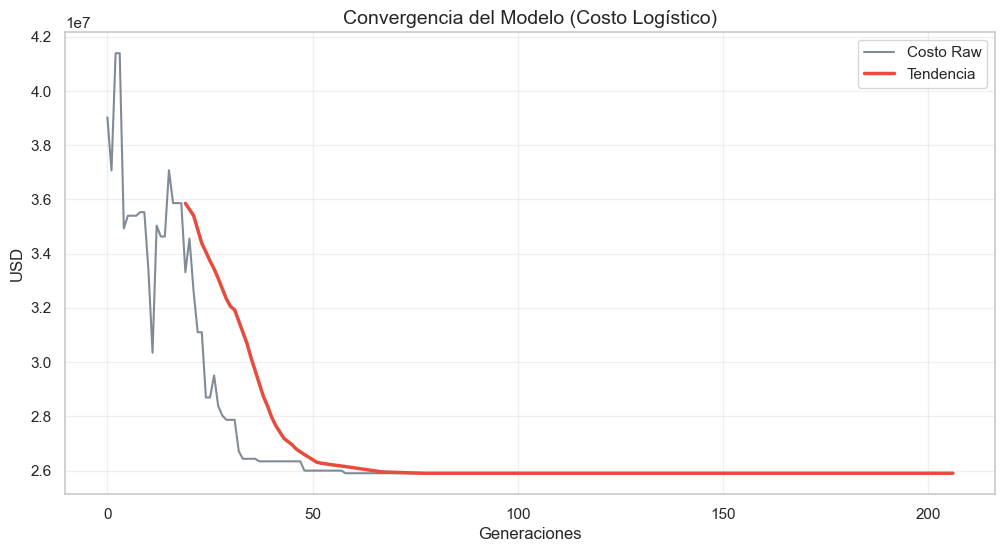


📄 TIPO DE INFORME: PRELIMINAR (EJECUCIÓN SIMPLE)

                       🕵️‍♂️ AUDITORÍA DE ZONAS DE RIESGO                       
🟡 ALERTA GESTIONADA (Ronda 16 Monza): Fecha 13-Aug. Desviación 19 días.
🟡 ALERTA GESTIONADA (Ronda 17 Bakú): Fecha 24-Aug. Desviación 8 días.
🟡 ALERTA GESTIONADA (Ronda 19 Las Vegas): Fecha 15-Sep. Desviación 30 días.

✅ RESULTADO: Calendario APROBADO. (Zonas Amarillas usadas: 3)

                        🏁 RESUMEN EJECUTIVO (CONSOLA) 🏁                         
Métrica              | Actual          | Optimizado      | Diferencia
----------------------------------------------------------------------
Distancia            | 114,521 km     | 99,534 km     | 📉 13.1%
Costo                | $29.8M       | $25.9M       | 💰 $3.9M
Emisiones            | 4,343 t     | 3,774 t     | 🌿 -568 t

📝 SNIPPET MARKDOWN FINAL

## 🚀 Resultados: Optimización Logística F1 (2025)

### 📊 Tabla de Impacto

| KPI | Calendario Oficial | Propuesta IA | Ahorro / Mejora |
| :--- | :--- |

In [5]:
# --- 5. EJECUCIÓN: INTERACTIVA (SIMPLE vs ROBUSTO) ---
if __name__ == "__main__":
    try:
        # 1. Configuración de Rutas
        FILE_CIRCUITS = '../data/f1_circuits.csv'
        FILE_PARAMS = '../data/model_parameters.csv'
        FILE_CALENDAR = '../data/f1_official_calendar.csv'
        FILE_CONSTR = '../data/race_constraints.csv'
        
        # 2. Carga de Datos
        data = F1LogisticsData(FILE_CIRCUITS, FILE_PARAMS, FILE_CONSTR)
        ruta_base = data.load_official_route(FILE_CALENDAR)
        
        idx_start, idx_end = data.get_fixed_start_end_indices()
        start_city = data.get_race_info(idx_start)['Ciudad']
        end_city = data.get_race_info(idx_end)['Ciudad']
        
        # --- MENÚ INTERACTIVO ---
        print("\n" + "="*60)
        print("🏎️  F1 LOGISTICS OPTIMIZER - MENÚ DE EJECUCIÓN")
        print("="*60)
        print("   [S] MODO SIMPLE  : 1 Ejecución (Rápido, ~4 min). Para pruebas.")
        print("   [R] MODO ROBUSTO : 5 Ejecuciones (Lento, ~25 min). Para validación final.")
        print("-" * 60)
        
        # Input de usuario
        modo = input("👉 Elige tu modo (S/R): ").strip().upper()
        
        if modo == 'R':
            NUM_INTENTOS = 5
            TIPO_REPORTE = "CERTIFICADO (ANÁLISIS ROBUSTO)"
            print(f"\n🚀 Iniciando MODO ROBUSTO (5 Iteraciones)... Ve por un café ☕.")
        else:
            NUM_INTENTOS = 1
            TIPO_REPORTE = "PRELIMINAR (EJECUCIÓN SIMPLE)"
            print(f"\n🚀 Iniciando MODO SIMPLE (1 Iteración)... Rápido y furioso 💨.")

        print(f"⚓ Anclas Activas: {start_city} -> {end_city}")
        print("-" * 60)

        best_run_score = float('inf')
        best_run_route = None
        best_run_history = []
        best_optimizer_state = None
        
        # Bucle de Ejecución
        for i in range(NUM_INTENTOS):
            # Configuración del Optimizador
            opt = SustainableOptimizer(data, pop_size=200, generations=1000, mutation_rate=0.25)
            ruta, score_total = opt.run()
            
            # Validación
            _, violations = opt._check_date_constraints(ruta)
            metricas = opt.fitness(ruta)
            costo_real = metricas[2]
            
            status = "✅ APROBADO" if violations == 0 else f"❌ FALLIDO ({violations} errores)"
            print(f"   ▶️ Run {i+1}/{NUM_INTENTOS}: Costo=${costo_real/1e6:.2f}M | {status}")
            
            # Guardar el mejor
            if violations == 0 and score_total < best_run_score:
                best_run_score = score_total
                best_run_route = ruta
                best_run_history = opt.history
                best_optimizer_state = opt

        print("-" * 60)
        
        # Generación de Resultados
        if best_run_route:
            print(f"🏆 MEJOR ESCENARIO SELECCIONADO ({TIPO_REPORTE})")
            viz = LogisticsVisualizer(data)
            
            # A. Gráfica
            viz.plot_convergence(best_run_history)
            
            # B. Mapa
            viz.create_side_by_side_map(ruta_base, best_run_route)
            
            # C. Reporte Consola (Agregamos etiqueta de tipo reporte)
            print(f"\n📄 TIPO DE INFORME: {TIPO_REPORTE}")
            viz.print_audit_details(best_run_route)
            viz.print_report(ruta_base, best_run_route, best_optimizer_state)
            
            # D. Markdown Web
            viz.generate_markdown_for_web(ruta_base, best_run_route, best_optimizer_state)
            
            # E. Dashboard HTML
            viz.generate_interactive_dashboard(ruta_base, best_run_route, best_optimizer_state, best_run_history)
            
            print("\n✅ PROCESO FINALIZADO CON ÉXITO.")
            print("   -> Revisa la carpeta 'outputs/' para ver los mapas y el dashboard.")
            
        else:
            print("⚠️ ADVERTENCIA: No se encontró ninguna ruta válida en las iteraciones realizadas.")

    except Exception as e:
        print(f"❌ ERROR: {e}")